In [3]:
sc.stop()

NameError: name 'sc' is not defined

In [4]:
from pyspark import SparkContext, SparkConf

conf = SparkConf().setMaster("local[*]")
sc = SparkContext(conf=conf)

In [5]:
import json

# create RDD of tweets from twitter json file
tweetsRDD = sc.textFile("/home/venkatr5/twitter_project/congress_tweets.jsonl").map(json.loads)

In [20]:
# count number of tweets by user
userTweetCountsRDD = (tweetsRDD
                 .map(lambda tweet: (tweet['user']['screen_name'], 1))
                 .reduceByKey(lambda a, b: a + b)
                )

# return users with most tweets
top50Users = userTweetCountsRDD.takeOrdered(50, lambda kv: -kv[1])

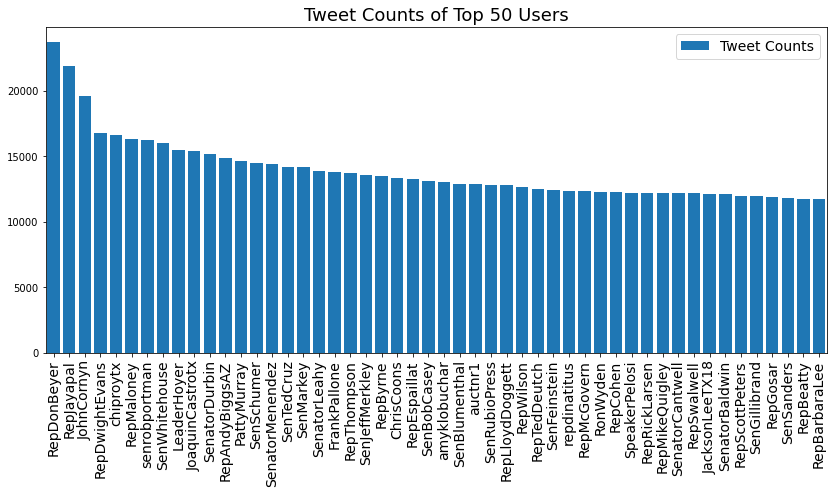

In [21]:
import matplotlib.pyplot as plt
import numpy as np

users = list()
counts = list()
for pair in top50Users:
    users.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts), label="Tweet Counts", align='center')
plt.xticks(range(1,51), users[:50], rotation=90, fontsize=14)
plt.title("Tweet Counts of Top 50 Users",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

In [22]:
# count number of hashtags
hashtagCountsRDD = (tweetsRDD
                    .flatMap(lambda tweet: [hashtag['text'].lower() for hashtag in tweet["entities"]["hashtags"]])
                    .map(lambda hashtag: (hashtag, 1))
                    .reduceByKey(lambda a, b: a + b)
                   )

# return most used hashtags
top50Hashtags = hashtagCountsRDD.takeOrdered(50, lambda kv: -kv[1])

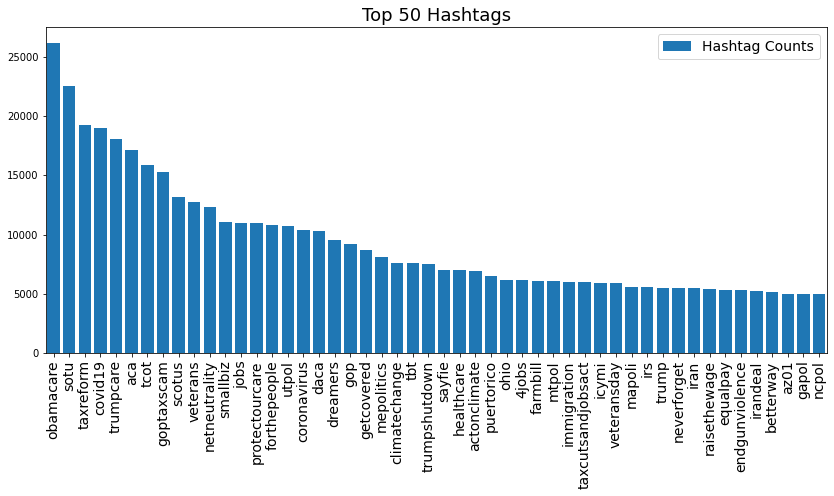

In [24]:
import matplotlib.pyplot as plt
import numpy as np

hashtags = list()
counts = list()
for pair in top50Hashtags:
    hashtags.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts), label="Hashtag Counts", align='center')
plt.xticks(range(1,51), hashtags[:50], rotation=90, fontsize=14)
plt.title("Top 50 Hashtags",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

In [28]:
# count number of user mentions
userMentionCountsRDD = (tweetsRDD
                        .flatMap(lambda tweet: [user_mention['screen_name'] for user_mention in tweet['entities']['user_mentions']])
                        .map(lambda user_mention: (user_mention, 1))
                        .reduceByKey(lambda a, b: a + b)
                       )

# return most user mentions
top50UserMentions = userMentionCountsRDD.takeOrdered(50, lambda kv: -kv[1])

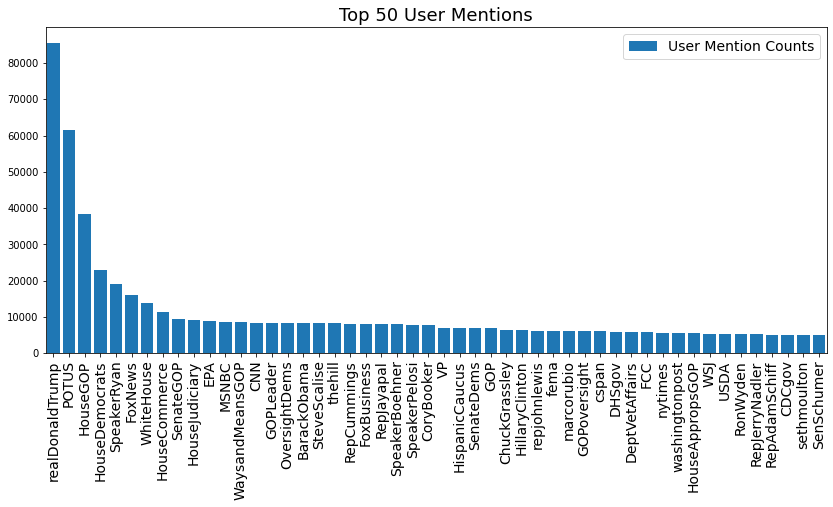

In [29]:
import matplotlib.pyplot as plt
import numpy as np

userMentions = list()
counts = list()
for pair in top50UserMentions:
    userMentions.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts), label="User Mention Counts", align='center')
plt.xticks(range(1,51), userMentions[:50], rotation=90, fontsize=14)
plt.title("Top 50 User Mentions",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

In [31]:
from datetime import datetime

def parseDate(x):
    return str(datetime.strptime(x,'%a %b %d %H:%M:%S +0000 %Y').strftime('%Y-%m-%d'))

# count number of tweets by date
tweetDateCountsRDD = (tweetsRDD
                    .map(lambda tweet: (parseDate(tweet['created_at']), 1))
                    .reduceByKey(lambda a, b: a + b)
                   )

# return most tweeted dates
top50Dates = tweetDateCountsRDD.takeOrdered(50, lambda kv: -kv[1])

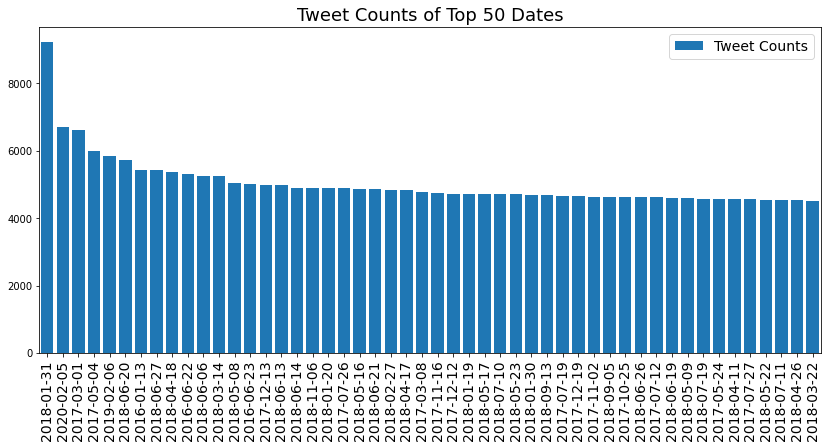

In [32]:
import matplotlib.pyplot as plt
import numpy as np

dates = list()
counts = list()
for pair in top50Dates:
    dates.append(pair[0])
    counts.append(pair[1])

plt.figure(figsize=(14,6))
plt.bar(range(1,51), np.array(counts), label="Tweet Counts", align='center')
plt.xticks(range(1,51), dates[:50], rotation=90, fontsize=14)
plt.title("Tweet Counts of Top 50 Dates",fontsize=18)
plt.legend(fontsize=14)
plt.xlim(0.5,50.5)
plt.show()

In [18]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import re
 
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
stop_words = stopwords.words('english') + list(string.punctuation) + ['rt', 'via', 'amp', '’', '…', '—', '“', '”'] 

def preprocessText(s):
    tokens = tokens_re.findall(s)
    tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# count number of words
wordCountsRDD = (tweetsRDD
             .flatMap(lambda tweet: [word for word in preprocessText(tweet['full_text'])])
             .map(lambda word: (word, 1))
             .reduceByKey(lambda a, b: a + b)
            )

# return most used words
wordCountsRDD.takeOrdered(100, lambda kv: -kv[1])

[('today', 428226),
 ('great', 255373),
 ('us', 211687),
 ('thank', 206699),
 ('people', 198991),
 ('bill', 198387),
 ('house', 196572),
 ('w', 194519),
 ('work', 190728),
 ('need', 186892),
 ('new', 186084),
 ('time', 178518),
 ('health', 178191),
 ('congress', 177331),
 ('trump', 175781),
 ('help', 175532),
 ('day', 173340),
 ('president', 172675),
 ('act', 172594),
 ('support', 171921),
 ('must', 171437),
 ('american', 147436),
 ('americans', 147371),
 ('thanks', 147012),
 ('families', 145772),
 ('care', 140834),
 ('proud', 140396),
 ('one', 136985),
 ('make', 134017),
 ('2', 133073),
 ('get', 131035),
 ('country', 120984),
 ('senate', 120574),
 ('women', 119659),
 ('see', 116461),
 ('would', 116053),
 ('vote', 115018),
 ('1', 114257),
 ('working', 111478),
 ('join', 110188),
 ('tax', 109473),
 ('state', 108710),
 ('like', 107744),
 ('week', 106502),
 ('th', 106252),
 ('community', 105454),
 ('last', 105104),
 ('first', 104389),
 ('year', 102598),
 ('u', 100399),
 ('happy', 97762),
